In [1]:
# Import the necessary library 
## Plotting Libraries 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import seaborn as sns
import scipy.signal as spy
import scipy

## Pyswmm engine with ICC 
from pyswmm_lite import Env

## Bayesian Optimization
import numpy as np
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts
import copy

In [2]:
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}


def run_swmm(valve_set1, valve_set2, valve_set3, valve_set4):
    env = Env("./networks/aa_0360min_025yr.inp")

    data = {}
    data["f1"] = []
    data["f2"] = []
    data["f3"] = []
    data["f4"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    data["overflow3"]  = []
    data["overflow4"]  = []
    done = False
    for i in range(0, 35000):
        # set the gate_position 
        env.set_gate(NODES_LIS["93-50077"], valve_set1)
        env.set_gate(NODES_LIS["93-50076"], valve_set2)
        env.set_gate(NODES_LIS["93-50081"], valve_set3)
        env.set_gate(NODES_LIS["93-49921"], valve_set4)
        
        # record_data
        data["f1"].append(env.flow(NODES_LIS["93-50077"]))
        data["f2"].append(env.flow(NODES_LIS["93-50076"]))
        data["f4"].append(env.flow(NODES_LIS["93-49921"]))
        data["f3"].append(env.flow(NODES_LIS["93-50081"]))
        
        data["overflow1"].append(env.sim._model.getNodeResult("93-50077", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("93-50076", 4))
        data["overflow4"].append(env.sim._model.getNodeResult("93-49921", 4))
        data["overflow3"].append(env.sim._model.getNodeResult("93-50081", 4))
        
        # step through simulation
        done = env.step()
        
    overflows = {}
    overflows["o1"] = sum(data["overflow1"])
    overflows["o2"] = sum(data["overflow2"])
    overflows["o3"] = sum(data["overflow3"])
    overflows["o4"] = sum(data["overflow4"])
    
    env.sim._model.swmm_end()
    env.sim._model.swmm_close()
    return data, overflows

# Plot the uncontrolled reponse 
un_data, un_overflow = run_swmm(1.0, 1.0, 1.0, 1.0)

In [3]:
# Desired control objective
downstream_target1 = np.asarray(copy.deepcopy(un_data["f1"]))
downstream_target1[downstream_target1 > 6.0] = 6.0
downstream_target1d =  spy.decimate(downstream_target1, 50)

In [4]:
def fc(x):
    data, overflow  = run_swmm(x[0][0], 1.0, 1.0, 1.0)
    pred_flow1 = np.asarray(data["f1"])
    pred_flow1 =  spy.decimate(pred_flow1, 50)
    path, distance1 = ts.dtw_path(downstream_target1d,
            pred_flow1,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)
    # sum of the outflows
    d = 0.0
    for i in overflow.keys():
        d += overflow[i]
    loss = distance1*10.0 + (d)*10.0
    return loss

In [5]:
# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 4)

myBopt.run_optimization(max_iter=10)

Text(0, 0.5, 'Outflow P1')

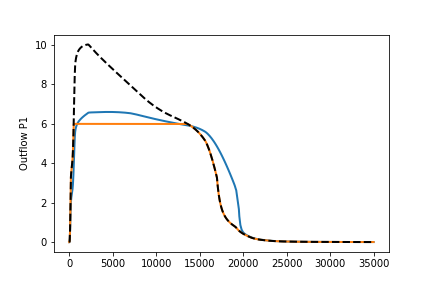

In [6]:
c_data, c_overflow = run_swmm(myBopt.x_opt[0], 1.0,1.0,1.0)
plt.plot(c_data["f1"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target1, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P1")

In [9]:
sum(c_data["f1"]) - sum(un_data["f1"])

-14279.176233438542

127577.86715022185

In [10]:
env = Env("./networks/parallel.inp")